# Supervised Incremental Improvements

6/27/2023

Plan:
- Make the network really good on pure synthetic data
- Try the network on noisy synthetic data
- Make the network really good on noisy synthetic data
- Try the network on observed data (GAIA and APOGEE labels)
- Make the network really good on observed data
- Try the network on unlabelled, observed data and plot results

In [1]:
import os
import numpy as np
import h5py
from collections import defaultdict
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torchsummary import summary

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using Torch version: %s' % (torch.__version__))
print('Using a %s device' % (device))

model_dir = 'models/'
data_dir = 'datasets/'
figure_dir = 'figures/'

label_keys = ['teff', 'feh', 'logg', 'alpha']
datasets = ['synth_clean', 'synth_noised', 'obs_GAIA', 'obs_APOGEE']



ADD_NOISE = False
model_identifier = 'obs_GAIA_medium'
train_data_file = os.path.join(data_dir, 'obs_GAIA.h5')


model_filename =  os.path.join(model_dir,model_identifier + '.pth.tar')

# Noise parameters
mean = 0
std = 0.03

# Synth_noised_1 and 2 are with the old method
# Synth_noised_3 and up are with the new method

Using Torch version: 1.13.1+cu117
Using a cuda device


## Datasets and Dataloader

In [2]:
class SimpleSpectraDataset(torch.utils.data.Dataset):
    
    """
    Dataset loader for the simple spectral datasets.
    """

    def __init__(self, data_file, dataset, label_keys):
        
        self.data_file = data_file
        self.dataset = dataset.lower()
        self.label_keys = label_keys
        # Determine the number of pixels in each spectrum
        self.num_pixels = self.determine_num_pixels()
        self.num_spectra = self.determine_num_spectra()
                        
    def __len__(self):
        return self.num_spectra
    
    def determine_num_spectra(self):
        with h5py.File(self.data_file, "r") as f:    
            count = len(f['spectra %s' % self.dataset])
        return count
    
    def determine_num_pixels(self):
        with h5py.File(self.data_file, "r") as f:    
            pixels = f['spectra %s' % self.dataset].shape[1]
        return pixels
    
    def __getitem__(self, idx):
        
        with h5py.File(self.data_file, "r") as f: 
                
            # Load spectrum
            spectrum = f['spectra %s' % self.dataset][idx]
            spectrum[spectrum<-1] = -1.
            spectrum = torch.from_numpy(spectrum.astype(np.float32))
            
            # Load target stellar labels
            data_keys = f.keys()
            labels = []
            for k in self.label_keys:
                data_key = k + ' %s' % self.dataset
                if data_key in data_keys:
                    labels.append(f[data_key][idx])
                else:
                    labels.append(np.nan)
            labels = torch.from_numpy(np.asarray(labels).astype(np.float32))
            
        # Return full spectrum and target labels
        return {'spectrum':spectrum,
                'labels':labels}
    
def batch_to_device(batch, device):
    '''Convert a batch of samples to the desired device.'''
    for k in batch.keys():
        if isinstance(batch[k], list):
            for i in range(len(batch[k])):
                batch[k][i] = batch[k][i].to(device)
        else:
            try:
                batch[k] = batch[k].to(device)
            except AttributeError:
                batch[k] = torch.tensor(batch[k]).to(device)
    return batch

Collect the necessary information to normalize the input spectra as well as the target labels. During training, the spectra and labels will be normalized to have approximately have a mean of zero and unit variance.

NOTE: This is necessary to put output labels on a similar scale in order for the model to train properly, this process is reversed in the test stage to give the output labels their proper units.

In [3]:
# Collect mean and std of the training data
with h5py.File(train_data_file, "r") as f:
    labels_mean = [np.nanmean(f[k + ' train'][:]) for k in label_keys]
    labels_std = [np.nanstd(f[k + ' train'][:]) for k in label_keys]
    spectra_mean = np.nanmean(f['spectra train'][:]) 
    spectra_std = np.nanstd(f['spectra train'][:])
    
batch_size = 16

# Training data
train_dataset = SimpleSpectraDataset(train_data_file, 
                                            dataset='train', 
                                            label_keys=label_keys)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                      batch_size=batch_size, 
                                                      shuffle=True, 
                                                      num_workers=1,
                                                      pin_memory=True)

# Validation data
val_dataset = SimpleSpectraDataset(train_data_file, 
                                         dataset='val', 
                                            label_keys=label_keys)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                                   batch_size=batch_size, 
                                                   shuffle=False, 
                                                   num_workers=1,
                                                   pin_memory=True)

print('The training set consists of %i spectra.' % (len(train_dataset)))
print('The validation set consists of %i spectra.' % (len(val_dataset)))

The training set consists of 166903 spectra.
The validation set consists of 3000 spectra.


## Construct model

The StarNet architecture is built with:
- input layer
- 2 convolutional layers
- 1 maxpooling layer followed by flattening for the fully connected layer
- 2 fully connected layers
- output layer

In [4]:
# Number of pixels per spectrum
num_pixels = train_dataset.num_pixels

# Number of filters used in the convolutional layers
num_filters = [4, 16]

# Length of the filters in the convolutional layers
filter_length = 8

# Length of the maxpooling window 
pool_length = 4

# Number of nodes in each of the hidden fully connected layers
num_hidden = [256, 128]

# Number of output labels
num_labels = len(label_keys)

def compute_out_size(in_size, mod):
    """
    Compute output size of Module `mod` given an input with size `in_size`.
    """
    
    f = mod.forward(autograd.Variable(torch.Tensor(1, *in_size)))
    return f.size()[1:]

class StarNet(nn.Module):
    def __init__(self, num_pixels, num_filters, filter_length, 
                 pool_length, num_hidden, num_labels,
                 spectra_mean, spectra_std, labels_mean, labels_std):
        super().__init__()
        
        # Save distribution of training data
        self.spectra_mean = spectra_mean
        self.spectra_std = spectra_std
        self.labels_mean = torch.tensor(np.asarray(labels_mean).astype(np.float32)).to(device)
        self.labels_std = torch.tensor(np.asarray(labels_std).astype(np.float32)).to(device)
        
        # Convolutional and pooling layers
        self.conv1 = nn.Conv1d(1, num_filters[0], filter_length)
        self.conv2 = nn.Conv1d(num_filters[0], num_filters[1], filter_length)
        self.pool = nn.MaxPool1d(pool_length, pool_length)
        
        # Determine shape after pooling
        pool_output_shape = compute_out_size((1,num_pixels), 
                                             nn.Sequential(self.conv1, 
                                                           self.conv2, 
                                                           self.pool))
        
        # Fully connected layers
        self.fc1 = nn.Linear(pool_output_shape[0]*pool_output_shape[1], num_hidden[0])
        self.fc2 = nn.Linear(num_hidden[0], num_hidden[1])
        self.output = nn.Linear(num_hidden[1], num_labels)

    def normalize(self, data, data_mean, data_std):
        '''Normalize inputs to have zero-mean and unit-variance.'''
        return (data - data_mean) / data_std
    
    def denormalize(self, data, data_mean, data_std):
        '''Undo the normalization to put the data back in the original scale.'''
        return data * data_std + data_mean
        
    def forward(self, x, norm_in=True, denorm_out=False):
        
        if norm_in:
            # Normalize spectra to have zero-mean and unit variance
            x = self.normalize(x, self.spectra_mean, self.spectra_std)
        
        x = F.relu(self.conv1(x.unsqueeze(1)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        
        if denorm_out:
            # Denormalize predictions to be on the original scale of the labels
            x = self.denormalize(x, self.labels_mean, self.labels_std)
            
        return x

model = StarNet(num_pixels, num_filters, filter_length, 
                pool_length, num_hidden, num_labels,
                spectra_mean, spectra_std, labels_mean, labels_std)
model = model.to(device)

summary(model, (num_pixels, ))

## Define optimizer
## The Adam optimizer is the gradient descent algorithm used for minimizing the loss function

# Initial learning rate for optimization algorithm
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), 
                             learning_rate,
                             weight_decay=0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 793]              36
            Conv1d-2              [-1, 16, 786]             528
         MaxPool1d-3              [-1, 16, 196]               0
            Linear-4                  [-1, 256]         803,072
            Linear-5                  [-1, 128]          32,896
            Linear-6                    [-1, 4]             516
Total params: 837,048
Trainable params: 837,048
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 3.19
Estimated Total Size (MB): 3.34
----------------------------------------------------------------


## Train Model

In [5]:
# Total number of batch iterations for training
total_batch_iters = int(1e5)
cur_iter = 0
verbose_iters = total_batch_iters/25
losses = defaultdict(list)
running_loss = []

print('Started Training...')

# Start timer
train_start_time = time.time()
iter_start_time = time.time()

# Continuously loop over the training set
while cur_iter < (total_batch_iters):
    for train_batch in train_dataloader:
        
        # Add noise to train_batch
        if (ADD_NOISE == True):
            train_batch['spectrum'] += torch.randn_like(train_batch['spectrum']) * std + mean
        
        # Set parameters to trainable
        model.train()
        
        # Switch to GPU if available
        train_batch = batch_to_device(train_batch, device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward propagation
        label_preds = model(train_batch['spectrum'], 
                            norm_in=True, 
                            denorm_out=False)
        
        # Compute mean-squared-error loss between predictions and normalized targets
        loss = torch.nn.MSELoss()(label_preds, 
                                  model.normalize(train_batch['labels'], 
                                                  model.labels_mean,
                                                  model.labels_std))
        
        # Back-propagation
        loss.backward()
        
        # Weight updates
        optimizer.step()
        
        # Save losses to find average later
        running_loss.append(float(loss))
        
        cur_iter += 1
        
        # Display progress
        if cur_iter % verbose_iters == 0:
            
            # Take average of training losses
            train_loss = np.nanmean(running_loss)
            running_loss = []
            
            # Set parameters to not trainable
            model.eval()
            
            # Evaluate on validation set and display losses
            with torch.no_grad():
                for val_batch in val_dataloader:
                    
                    # Add noise to val_batch
                    if (ADD_NOISE == True):
                        val_batch['spectrum'] += torch.randn_like(val_batch['spectrum']) * std + mean

                    # Switch to GPU if available
                    val_batch = batch_to_device(val_batch, device)

                    # Forward propagation
                    label_preds = model(val_batch['spectrum'], 
                                        norm_in=True, 
                                        denorm_out=False)

                    # Compute mean-squared-error loss between predictions and normalized targets
                    loss = torch.nn.MSELoss()(label_preds, 
                                              model.normalize(val_batch['labels'], 
                                                              model.labels_mean,
                                                              model.labels_std))
                    # Save losses to find average later
                    running_loss.append(float(loss))
                    
            # Average validation loss
            val_loss = np.nanmean(running_loss)
            running_loss = []
            
            losses['train_loss'].append(train_loss)
            losses['val_loss'].append(val_loss)

            # Print progress
            print('[Iter %i, %0.0f%%]' % (cur_iter, cur_iter/total_batch_iters*100))
            print('\tTrain Loss: %0.4f' % (train_loss))
            print('\tVal Loss: %0.4f' % (val_loss))
            print('\tTime taken: %0.0f seconds' % (time.time() - iter_start_time))
            
            # Save model
            torch.save({'optimizer' : optimizer.state_dict(),
                        'model' : model.state_dict(), 
                        'batch_iters' : cur_iter,
                        'losses' : losses,
                        'train_time' : time.time() - train_start_time},
                       model_filename)
            
            iter_start_time = time.time()
            
        if cur_iter >= total_batch_iters:
            # Save model
            torch.save({'optimizer' : optimizer.state_dict(),
                        'model' : model.state_dict(), 
                        'batch_iters' : cur_iter,
                        'losses' : losses,
                        'train_time' : time.time() - train_start_time},
                       model_filename)
            print('Finished Training')
            print('Total time taken: %0.0f seconds' % (time.time() - train_start_time))
            break

Started Training...
[Iter 4000, 4%]
	Train Loss: 0.1990
	Val Loss: 0.1223
	Time taken: 203 seconds
[Iter 8000, 8%]
	Train Loss: 0.1376
	Val Loss: 0.1143
	Time taken: 222 seconds
[Iter 12000, 12%]
	Train Loss: 0.1226
	Val Loss: 0.1225
	Time taken: 197 seconds
[Iter 16000, 16%]
	Train Loss: 0.1119
	Val Loss: 0.1144
	Time taken: 206 seconds
[Iter 20000, 20%]
	Train Loss: 0.1118
	Val Loss: 0.1068
	Time taken: 212 seconds
[Iter 24000, 24%]
	Train Loss: 0.1019
	Val Loss: 0.0932
	Time taken: 204 seconds
[Iter 28000, 28%]
	Train Loss: 0.0995
	Val Loss: 0.0875
	Time taken: 204 seconds
[Iter 32000, 32%]
	Train Loss: 0.0970
	Val Loss: 0.0932
	Time taken: 229 seconds
[Iter 36000, 36%]
	Train Loss: 0.0924
	Val Loss: 0.0869
	Time taken: 199 seconds
[Iter 40000, 40%]
	Train Loss: 0.0892
	Val Loss: 0.0999
	Time taken: 193 seconds
[Iter 44000, 44%]
	Train Loss: 0.0899
	Val Loss: 0.0906
	Time taken: 217 seconds
[Iter 48000, 48%]
	Train Loss: 0.0838
	Val Loss: 0.0935
	Time taken: 200 seconds
[Iter 52000,

## Plot training progress
Let's see train and validation loss over the iterations

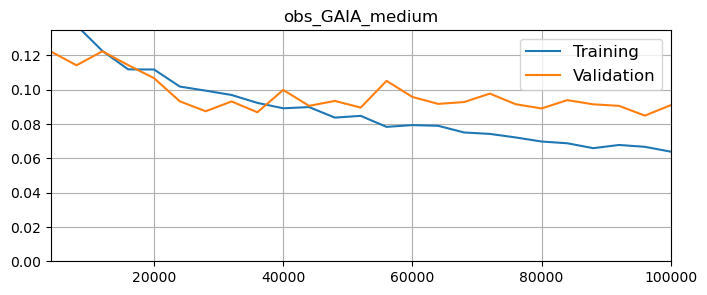

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))

# Determine iteration of checkpoint
batch_iters = np.linspace(cur_iter/len(losses['train_loss']), 
                          cur_iter, len(losses['train_loss']))

# Plot training and validation progress
plt.plot(batch_iters, losses['train_loss'], label='Training')
plt.plot(batch_iters, losses['val_loss'], label='Validation')
plt.xlim(batch_iters[0], batch_iters[-1])
plt.ylim(0, 1.1*losses['val_loss'][2])
plt.legend(fontsize=12)
plt.grid()
plt.title(model_identifier)
plt.savefig(figure_dir + model_identifier + ".png")
plt.show()

## Apply model to datasets
Let's compare our predictions to their real labels

### Load model

In [7]:
# Load model info
if True == False:
    load_model = os.path.join(model_dir,'cnn_synth_clean_1.pth.tar')

    checkpoint = torch.load(load_model, 
                            map_location=lambda storage, loc: storage)
    losses = dict(checkpoint['losses'])
    cur_iter = checkpoint['batch_iters']

    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer'])

    # Load model weights
    model.load_state_dict(checkpoint['model'])

### Get Validation Data

In [8]:
# Get validation data
batch_size = 16

val_datasets = {}
val_dataloaders = {}
for dataset in datasets:
    load_path = os.path.join(data_dir, dataset+'.h5')
    val_datasets[dataset] = SimpleSpectraDataset(load_path, 
                                       dataset='val', 
                                       label_keys=label_keys)

    val_dataloaders[dataset] = torch.utils.data.DataLoader(val_datasets[dataset],
                                                   batch_size=batch_size, 
                                                   shuffle=False, 
                                                   num_workers=1,
                                                   pin_memory=True)
    print("Created dataset for " + dataset + " with size " + str(len(val_datasets[dataset])))

# Set parameters to not trainable
model.eval()

# Predict labels of the validation spectra
ground_truth_labels = {}
model_pred_labels = {}

print("Started predicting labels")
with torch.no_grad():
    for dataset in datasets:
        ground_truth_labels[dataset] = []
        model_pred_labels[dataset] = []
            
        current_dataloader = val_dataloaders[dataset]
        for val_batch in current_dataloader:
            # Switch to GPU if available
            val_batch = batch_to_device(val_batch, device)

            # Forward propagation (and denormalize outputs)
            label_preds = model(val_batch['spectrum'], 
                                norm_in=True, 
                                denorm_out=True)

            # Save batch data for comparisons
            ground_truth_labels[dataset].append(val_batch['labels'].cpu().data.numpy())
            model_pred_labels[dataset].append(label_preds.cpu().data.numpy())
        
        ground_truth_labels[dataset] = np.concatenate(ground_truth_labels[dataset])
        model_pred_labels[dataset] = np.concatenate(model_pred_labels[dataset])
        print("\tPredicted labels for " + dataset)
print("Done!")

Created dataset for synth_clean with size 3000
Created dataset for synth_noised with size 3000
Created dataset for obs_GAIA with size 3000
Created dataset for obs_APOGEE with size 3000
Started predicting labels
	Predicted labels for synth_clean
	Predicted labels for synth_noised
	Predicted labels for obs_GAIA
	Predicted labels for obs_APOGEE
Done!


### Plotting helper functions

In [9]:
def pretty(label):
    label_fancy = label
    
    if label=='teff':
        label_fancy = 'T$_{\mathrm{eff}}$ [K]'
    if label=='feh':
        label_fancy = '[Fe/H]'
    if label=='logg':
        label_fancy = 'log(g)'
    if label=='alpha':
        label_fancy = r'[$\alpha$/H]'
        
    if label=='synth_clean':
        label_fancy = 'Synthetic Data'
    if label=='synth_noised':
        label_fancy = 'Synthetic Data, Added Noise'
    if label=='obs_GAIA':
        label_fancy = 'Observed Data, GAIA Labels'
    if label=='obs_APOGEE':
        label_fancy = 'Observed Data, APOGEE Labels'
        
    return label_fancy

def getColor(dataset):
    color = 'blue'
    
    if dataset=='synth_clean':
        color = 'violet'
    if dataset=='synth_noised':
        color = 'violet'
    if dataset=='obs_GAIA':
        color = 'forestgreen'
    if dataset=='obs_APOGEE':
        color = 'forestgreen'
    
    return color

### Plot Performance on Validation Sets

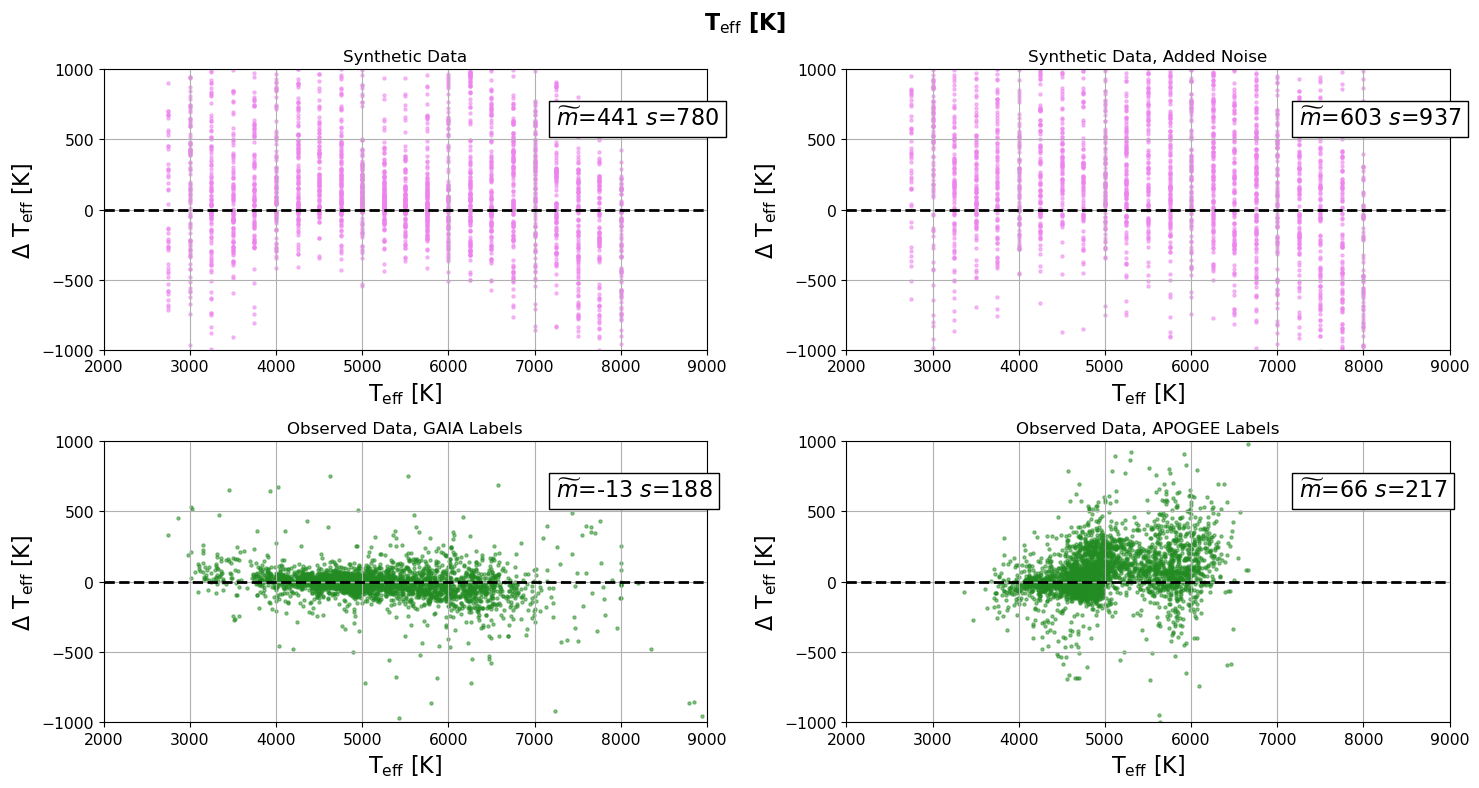

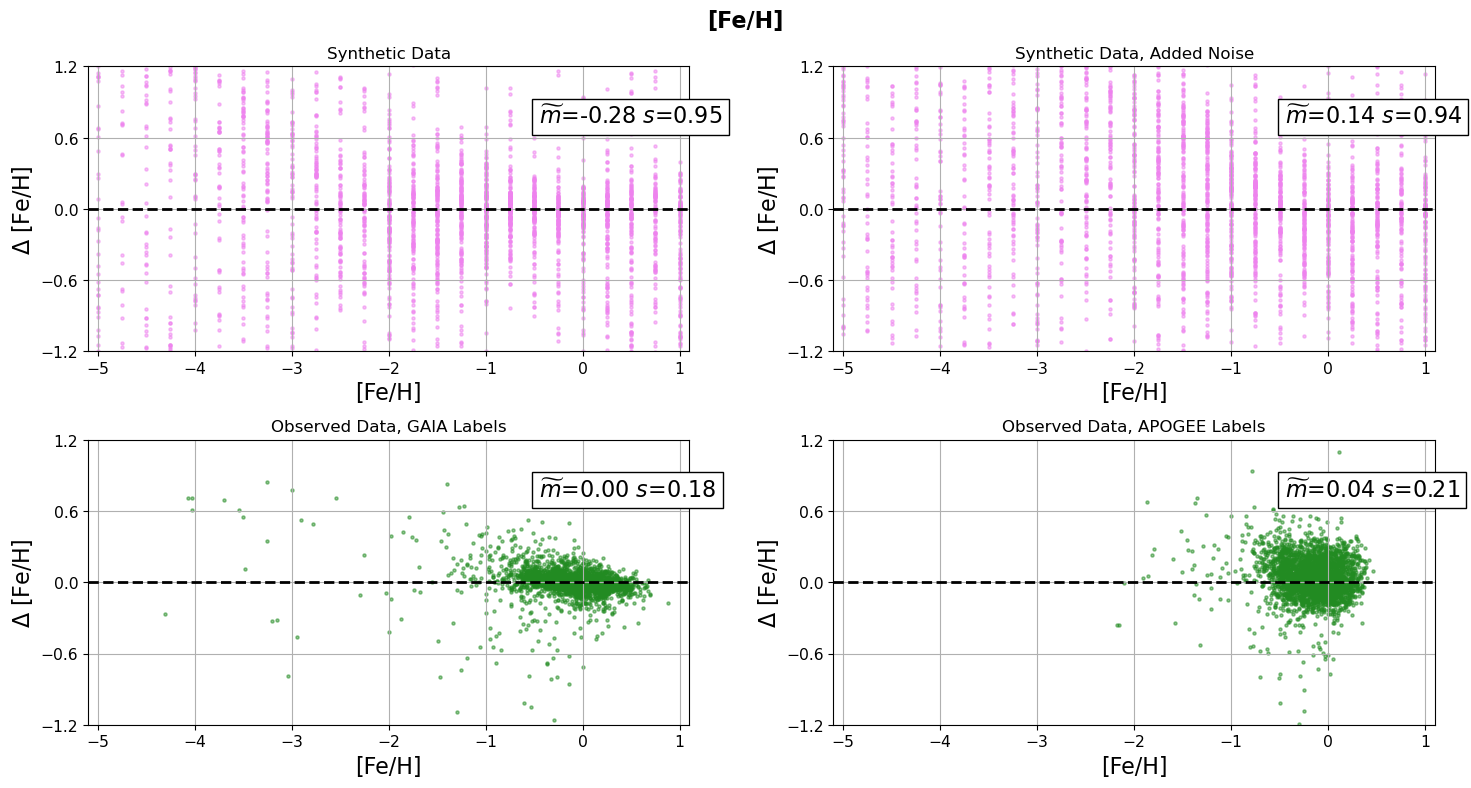

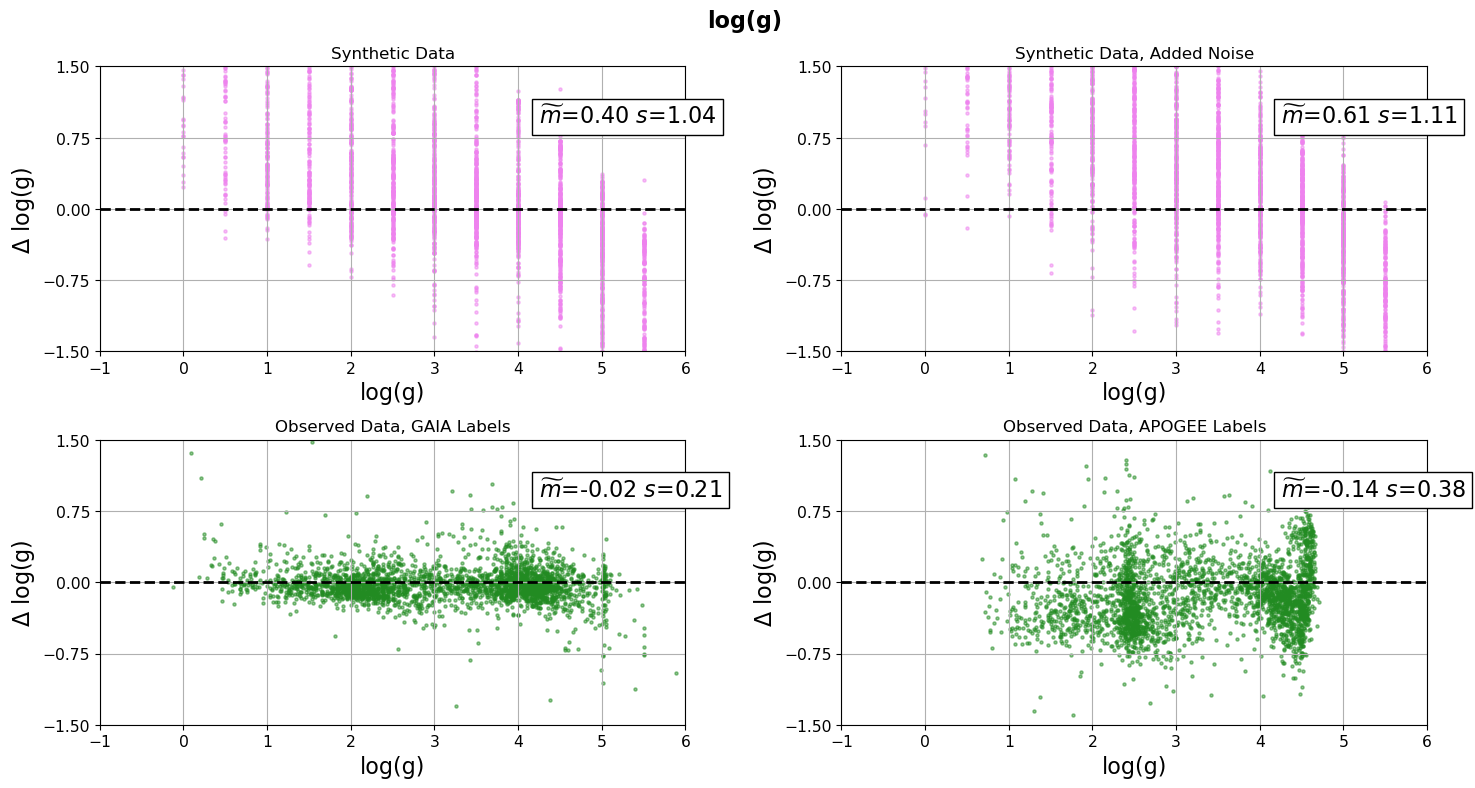

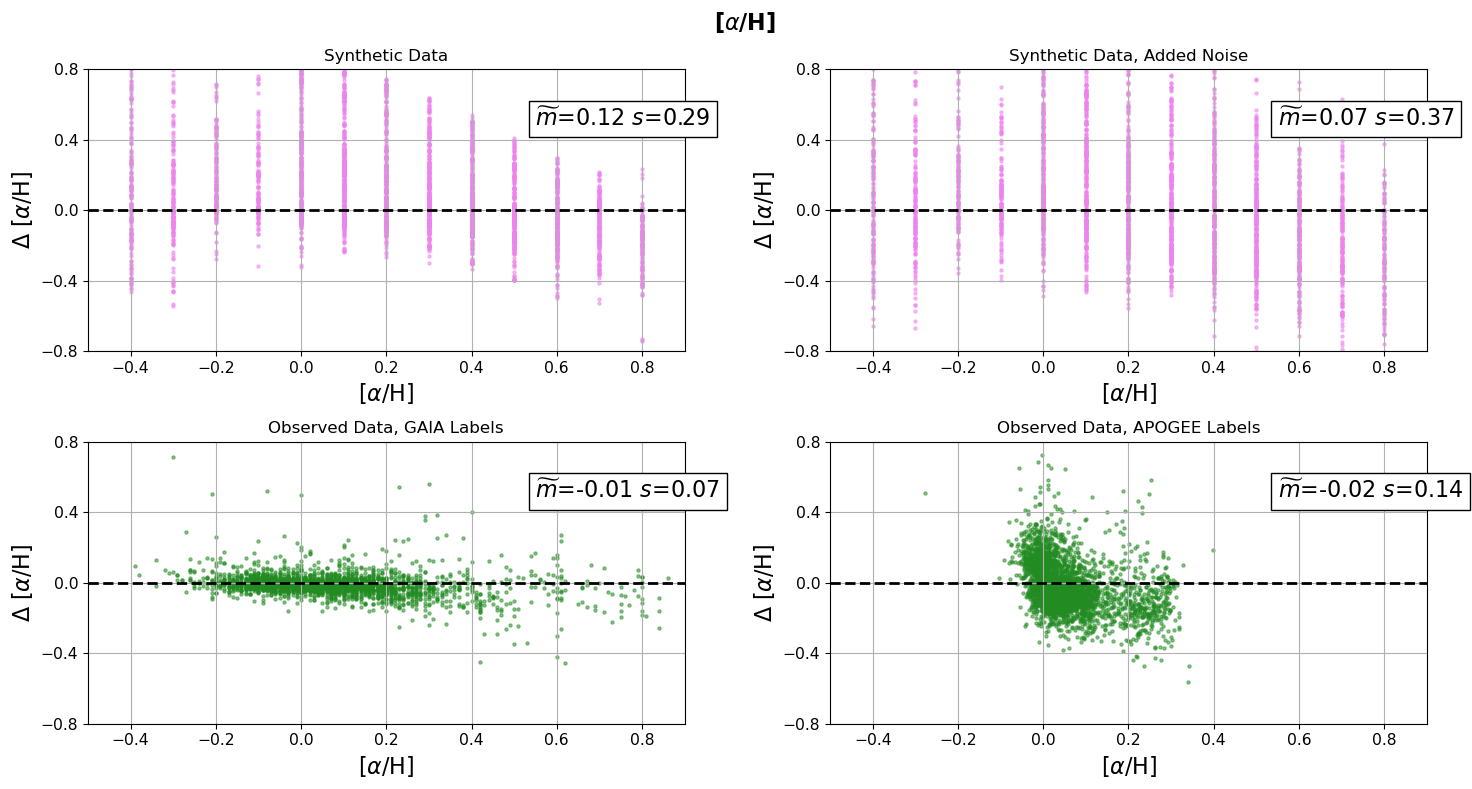

In [10]:
y_lims = [1000, 1.2, 1.5, 0.8]
x_lims = [[2000, 9000],
          [-5.1, 1.1],
          [-1, 6],
          [-0.5, 0.9]]
saving = True

for i, label in enumerate(label_keys):
    # Create the main figure and set the title
    pretty_label = pretty(label)
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(pretty_label, fontsize=16, fontweight='bold')

    # Iterate through the labels and create subplots
    for j, dataset in enumerate(datasets):
        # Create a subplot in the 2x2 grid
        ax = fig.add_subplot(2, 2, j+1)
        
        # Calculate residual
        diff = model_pred_labels[dataset][:,i] - ground_truth_labels[dataset][:,i]
        
        # Create scatter plot on the given axes
        color = getColor(dataset)
        ax.scatter(ground_truth_labels[dataset][:,i], diff, alpha=0.5, s=5, zorder=1, c=color)

        # Customize each subplot
        pretty_dataset = pretty(dataset)
        ax.set_title(pretty_dataset)
        ax.set_xlabel(pretty_label, size=4*len(label_keys))
        ax.set_ylabel(r'$\Delta$ %s' % pretty_label, size=4*len(label_keys))
        
        # Add mean and spread information
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
        if 'eff' in label:
            ax.annotate('$\widetilde{m}$=%0.0f $s$=%0.0f'% (np.nanmean(diff), np.nanstd(diff)),
                        (0.75,0.8), size=4*len(label_keys), xycoords='axes fraction', 
                        bbox=bbox_props)
        else:
            ax.annotate('$\widetilde{m}$=%0.2f $s$=%0.2f'% (np.nanmean(diff), np.nanstd(diff)),
                    (0.75,0.8), size=4*len(label_keys), xycoords='axes fraction', 
                    bbox=bbox_props)
        
        ax.axhline(0, linewidth=2, c='black', linestyle='--')
        ax.set_ylim(-y_lims[i], y_lims[i])
        ax.set_xlim(x_lims[i][0], x_lims[i][1])
        ax.set_yticks([-y_lims[i], -0.5*y_lims[i], 0, 0.5*y_lims[i], y_lims[i]])
        ax.tick_params(labelsize=2.8*len(label_keys))
        ax.grid()
    
    # Adjust the spacing between subplots
    fig.tight_layout()
    
    # Save the figure
    if saving is True:
        savename = figure_dir + model_identifier + '_' + label + '.png'
        plt.savefig(savename, facecolor='white', transparent=False, dpi=100,
                    bbox_inches='tight', pad_inches=0.05)

    # Show the figure
    plt.show()

### Plot Isochrones

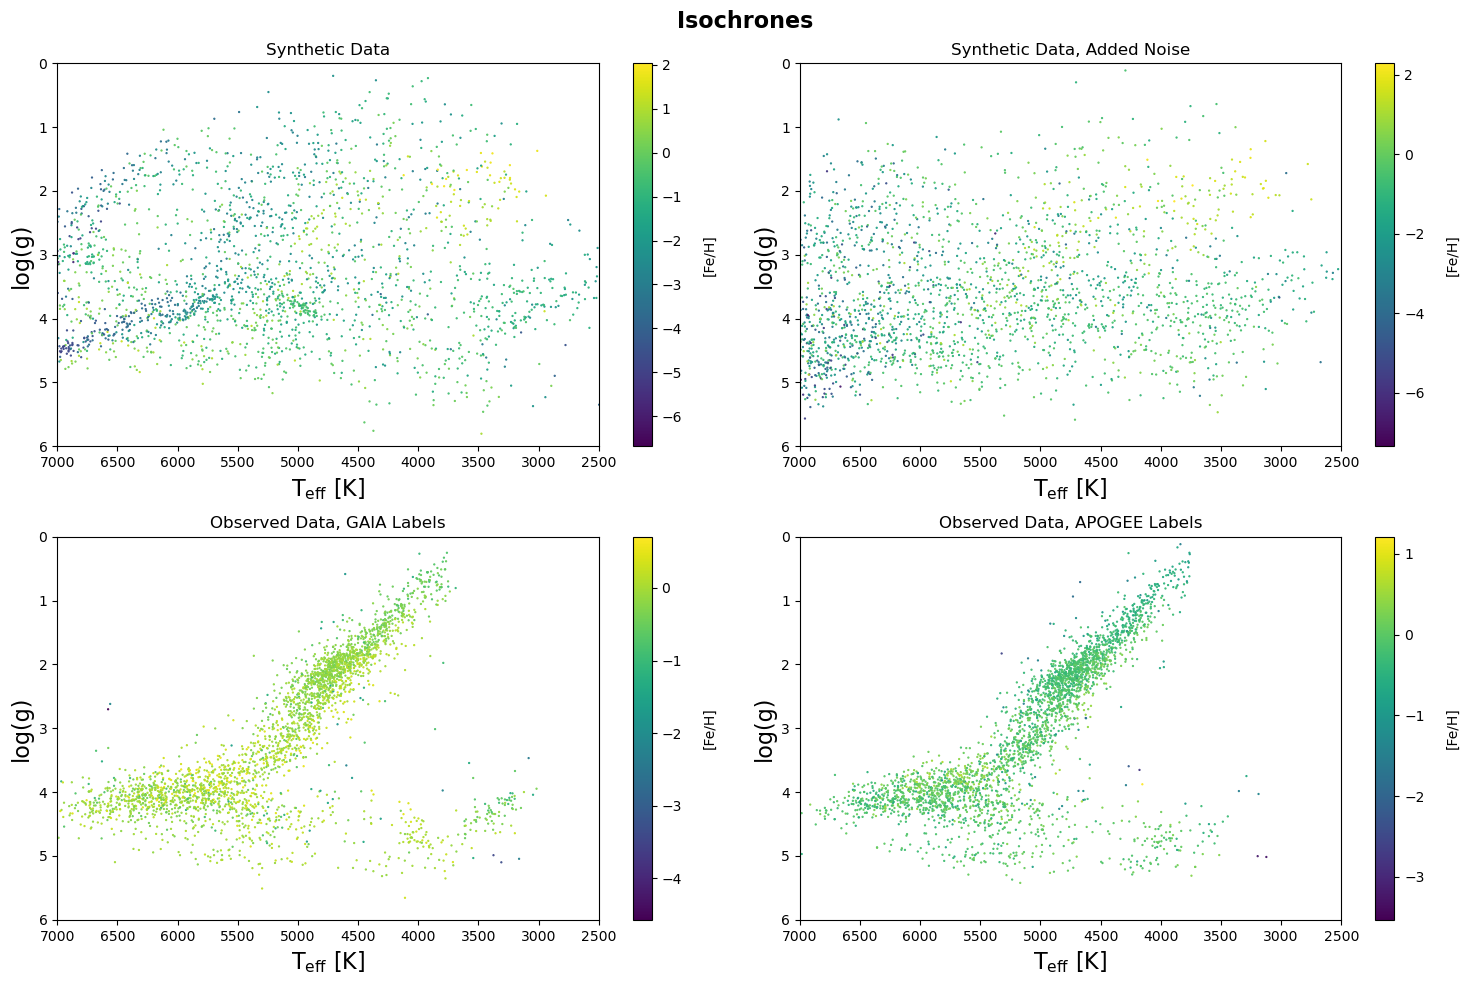

In [11]:
# Create the main figure and set the title
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Isochrones', fontsize=16, fontweight='bold')

# Iterate through the labels and create subplots
for j, dataset in enumerate(datasets):
    # Create a subplot in the 2x2 grid
    ax = fig.add_subplot(2, 2, j+1)

    scatter = ax.scatter(model_pred_labels[dataset][:,0], model_pred_labels[dataset][:,2], c=model_pred_labels[dataset][:,1], cmap='viridis', s=0.4)
    
    # Customize each subplot
    pretty_dataset = pretty(dataset)
    ax.set_title(pretty_dataset)
    ax.set_xlabel(pretty('teff'), size=4*len(label_keys))
    ax.set_ylabel(pretty('logg'), size=4*len(label_keys))

    # Show colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(pretty('feh'), rotation=90, labelpad=15)
    
    ax.set_ylim(6, 0)
    ax.set_xlim(7000, 2500)

# Adjust the spacing between subplots
fig.tight_layout()

# Save the figure
if saving is True:
    savename = figure_dir + model_identifier + '_isochrones.png'
    plt.savefig(savename, facecolor='white', transparent=False, dpi=100,
                bbox_inches='tight', pad_inches=0.05)

# Show the figure
plt.show()